In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [3]:
 import os
import urllib.request

if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    url = 'https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg'
    urllib.request.urlretrieve(url, 'dog.jpg')
    print('dog.jpg downloaded successfully')


dog.jpg exists


In [4]:
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


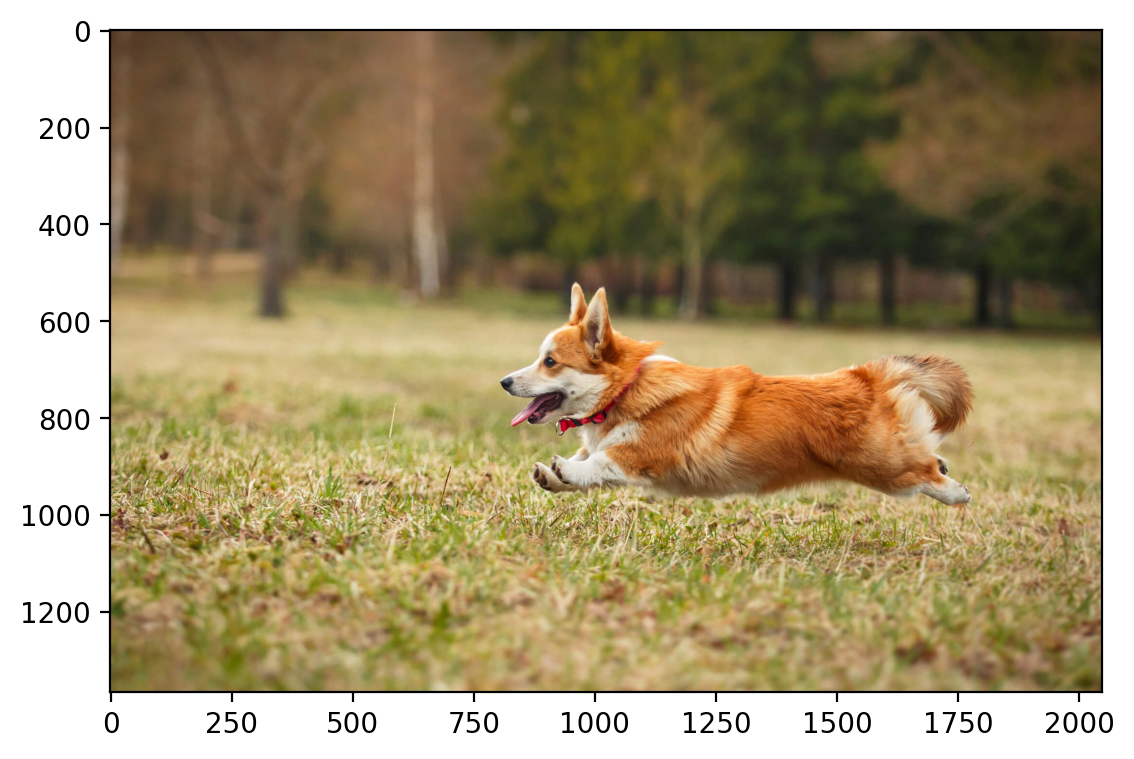

In [5]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [6]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [7]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

img_scaled = img_scaled.to(device)
img_scaled.shape

torch.Size([3, 1365, 2048])

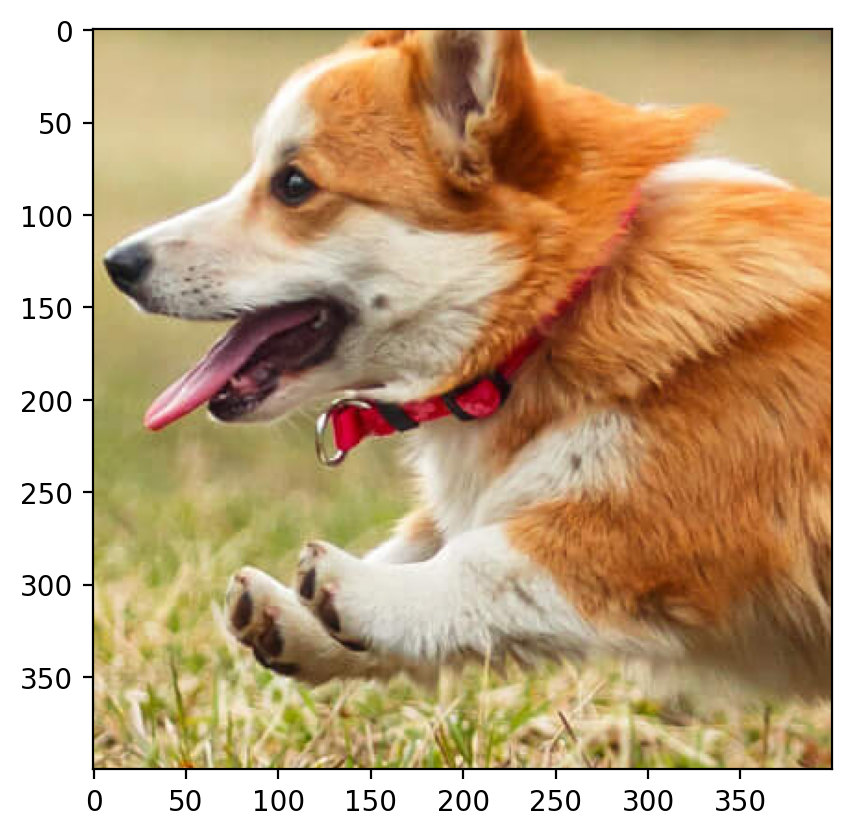

In [8]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 400, 400)
crop.shape

plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [9]:
crop = crop.to(device)

In [10]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 400 400


In [11]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y
resized_crop_200 = torchvision.transforms.functional.resize(crop, (200, 200))
resized_crop_200 = resized_crop_200.to(device)
dog_X_200, dog_Y_200 = create_coordinate_map(resized_crop_200)

dog_Y_200.shape

torch.Size([40000, 3])

In [12]:
num_channels, height, width = 2, 3, 4


# Create a 2D grid of (x,y) coordinates
w_coords = torch.arange(width).repeat(height, 1)
h_coords = torch.arange(height).repeat(width, 1).t()
w_coords = w_coords.reshape(-1)
h_coords = h_coords.reshape(-1)

# Combine the x and y coordinates into a single tensor
X = torch.stack([h_coords, w_coords], dim=1).float()

X

tensor([[0., 0.],
        [0., 1.],
        [0., 2.],
        [0., 3.],
        [1., 0.],
        [1., 1.],
        [1., 2.],
        [1., 3.],
        [2., 0.],
        [2., 1.],
        [2., 2.],
        [2., 3.]])

In [13]:
X.shape

torch.Size([12, 2])

In [14]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [15]:
dog_X, dog_Y_ = create_coordinate_map(crop)

dog_X.shape, dog_Y.shape

NameError: name 'dog_Y' is not defined

In [16]:
dog_X

tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [399., 397.],
        [399., 398.],
        [399., 399.]], device='cuda:0')

In [17]:
import torch
from einops import rearrange

def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width, 2)  # Selecting alternating columns
    h_coords = torch.arange(0, height, 2)  # Selecting alternating rows

    # Create meshgrid
    w_coords, h_coords = torch.meshgrid(w_coords, h_coords)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords.flatten(), w_coords.flatten()], dim=1).float()

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()

    # Filter Y to only contain values corresponding to selected coordinates in X
    indices = X[:, 0] * width + X[:, 1]
    Y = Y[indices.long()]

    return X, Y

# Assuming you have the image tensor named 'image_tensor'
# Replace this with your actual image tensor

X, Y = create_coordinate_map(crop)
print("X shape:", X.shape)
print("Y shape:", Y.shape)


X shape: torch.Size([40000, 2])
Y shape: torch.Size([40000, 3])


In [18]:
X

tensor([[  0.,   0.],
        [  2.,   0.],
        [  4.,   0.],
        ...,
        [394., 398.],
        [396., 398.],
        [398., 398.]])

In [19]:
Y

tensor([[0.7686, 0.6941, 0.4745],
        [0.7765, 0.7020, 0.4824],
        [0.7882, 0.7137, 0.4941],
        ...,
        [0.6196, 0.3765, 0.1451],
        [0.6118, 0.3765, 0.1333],
        [0.7059, 0.5137, 0.2941]], device='cuda:0')

In [20]:
dog_Y.shape

NameError: name 'dog_Y' is not defined

In [21]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

In [22]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())
dog_X_scaled2 = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled2 = torch.tensor(dog_X_scaled2).to(device)

# Set to dtype float32
dog_X_scaled2 = dog_X_scaled2.float()

In [23]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


In [24]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [25]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape

    print(height)
    print(width)
    print(num_channels)
    print(original_img.shape)
    X.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        print(outputs.shape)
        outputs = outputs.reshape(height, width, num_channels)
        outputs = outputs.permute(1, 2, 0)

    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [26]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [27]:
X_rff = create_rff_features(dog_X_scaled, 9000, 0.008)

In [28]:
dogX_rff = create_rff_features(dog_X_scaled2, 9000, 0.008)

In [29]:
dogX_rff.shape

torch.Size([160000, 9000])

In [30]:
X_rff.shape

torch.Size([40000, 9000])

In [53]:
X_rff_train = []
for i in range(0,400):
  if (i%2 != 0):
    continue
  for j in range(0,400,2):
    X_rff_train.append(dogX_rff[i*400 + j])

In [55]:

print(dog_Y_200.shape)
net = LinearModel(X_rff.shape[1], 3)
net.to(device)
X_rff_train = torch.stack(X_rff_train)
train(net, 0.005, X_rff_train, dog_Y_200, 2500)

torch.Size([40000, 3])
Epoch 0 loss: 0.370659
Epoch 100 loss: 0.057718
Epoch 200 loss: 0.020191
Epoch 300 loss: 0.015786
Epoch 400 loss: 0.014041
Epoch 500 loss: 0.012871
Epoch 600 loss: 0.011995
Epoch 700 loss: 0.011305
Epoch 800 loss: 0.010741
Epoch 900 loss: 0.010270
Epoch 1000 loss: 0.009870
Epoch 1100 loss: 0.009524
Epoch 1200 loss: 0.009222
Epoch 1300 loss: 0.008955
Epoch 1400 loss: 0.008716
Epoch 1500 loss: 0.008501
Epoch 1600 loss: 0.008305
Epoch 1700 loss: 0.008126
Epoch 1800 loss: 0.007962
Epoch 1900 loss: 0.007809
Epoch 2000 loss: 0.007666
Epoch 2100 loss: 0.007533
Epoch 2200 loss: 0.007408
Epoch 2300 loss: 0.007289
Epoch 2400 loss: 0.007177


0.007071646396070719

In [35]:
file_path = './linear_model.pth'
torch.save(net.state_dict(), file_path)
net = LinearModel(X_rff.shape[1], 3)
net.load_state_dict(torch.load(file_path))
net.eval()

LinearModel(
  (linear): Linear(in_features=9000, out_features=3, bias=True)
)

In [51]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [46]:
print(X.shape)
print(X_rff.shape)

torch.Size([40000, 2])
torch.Size([40000, 9000])


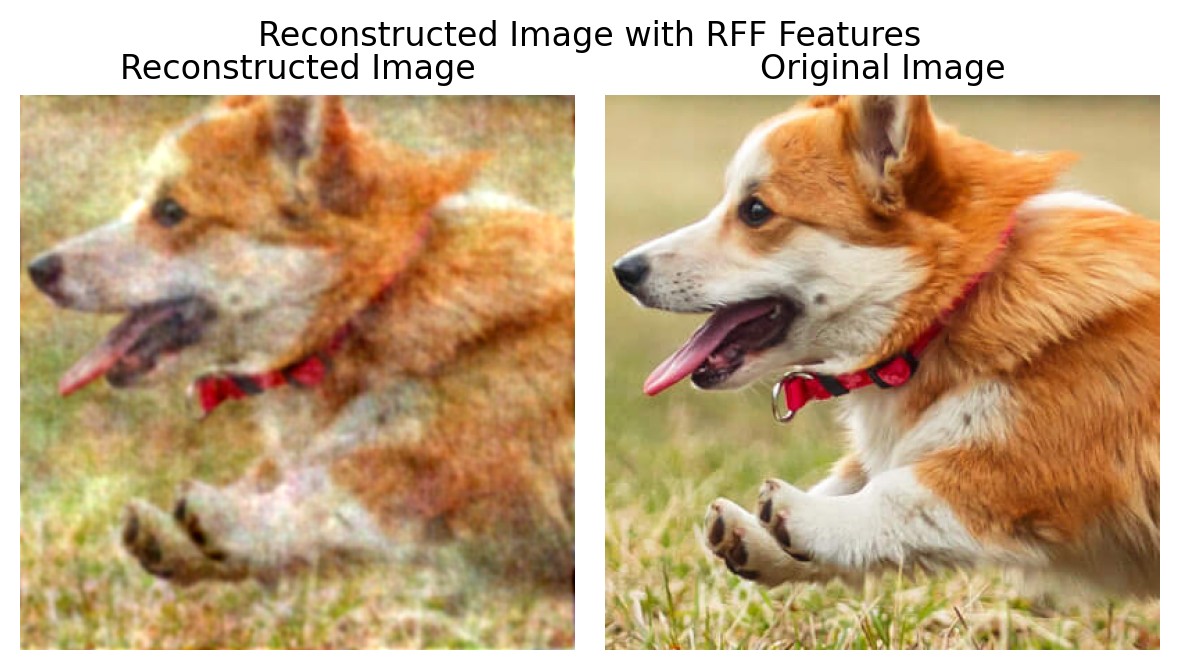

In [52]:
plot_reconstructed_and_original_image(crop, net, dogX_rff, title="Reconstructed Image with RFF Features")